<a href="https://colab.research.google.com/github/stefanlessmann/ASE-ML/blob/main/SHAPdemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summer School Demo on Explainable AI (XAI) Using Global and Local Explanation Methods
Once we went through so many slides, it is certainly time to see some Python code. We begin with a demo of the Shap framework. Subsequently, there is place for you to further develop your programming skills by working on some exercises (no worries, not too difficult).

In [1]:
# Standard libraries for data data handling and plotting
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# The SHAP Framework
In the interest of time, we focus this notebook to SHAP. In case you miss demos of the other XAI approaches we discussed, like PDPs, permutation importance, etc. you can take a look into [this demo](https://github.com/stefanlessmann/ASE-ML/blob/main/Day-4-Practice.ipynb), which we created for an ML course previously taught at ASE. It features all the explanation methods we discussed.

## Installing the SHAP library
Depending on your system setup and from where you run this notebook, you might have to install the SHAP library.

In [ ]:
# !pip install shap
# or
# conda install -c conda-forge shap

Likewise, the demo uses XGB, which may or maynot be available on your machine and thus require installation.

In [ ]:
# !pip install xgboost
# or
# conda install py-xgboost

Load packages specifically needed for the following demo.

In [2]:
# SHAP for local explanation
import shap
import xgboost

shap.initjs()  # Init Java Script for subsequent plots

## California housing data set

In [3]:
from sklearn import datasets

calif = datasets.fetch_california_housing(as_frame=True)

X, y = calif.data, calif.target  # we use the variables for ML

print(calif.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
# For data exploration, you can access the feature matrix as DataFrame
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((14448, 8), (6192, 8), (14448,), (6192,))

## Model development 
Next we train an XGB model on the data and compute test set predictions

In [6]:
from sklearn.metrics import mean_squared_error

# Model training 
model = xgboost.XGBRegressor().fit(Xtrain, ytrain)

# Test set prediction 
yhat = model.predict(Xtest)

# Model evaluation
rmse = mean_squared_error(ytest, yhat, squared=False)

print("Model RMSE:", rmse)

Model RMSE: 0.46956874046061864


Now that we have an idea how accurate our XGB model predicts, it is time to explain its predictions using SHAP.

## Local explanations
First (and key) step is to compute the Shapley values, more specifically, their approximation, which we achieve as follows. Note that this code my need some time to run. 

In [7]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

The beauty of the package is that we can now call upon a rich set of informative plots to explain individual-level (i.e., local) predictions. We begin with illustrating the *waterfall* plot, which is arguably the most intuitive visualization.

### Waterfall plot

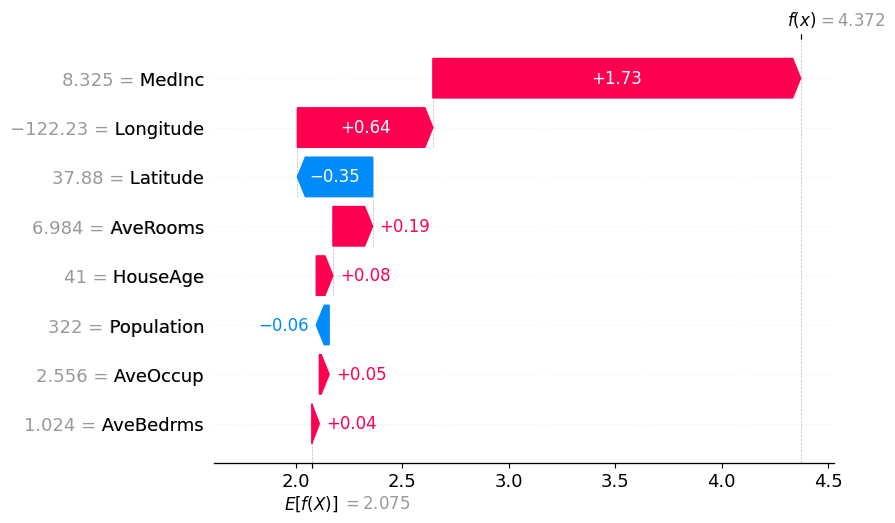

In [8]:
test_point = 0  # One instance from the data arbitrarily chosen

shap.plots.waterfall(shap_values[test_point])

The above explanation shows how individual feature **values** contribute to the model prediction shown in the upper right corner. More specifically, the SHAP values shown on the x-axis capture the amoung by which the feature values push the model forecast from the base value (the average model prediction over the training data) to the model forecast for this specific instance. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.
Play a bit with code by, e.g., visualizing the SHAP values for other instances.

The SHAP package offers several other plots a famous example of which is the *force_plot*. The force_plot also serves local explainability, meaning is visualizes the same information as before, just differently.

### Force plot


In [9]:
shap.plots.force(shap_values[test_point])

## Global explanations
Intuitively, repeating the steps of explaining the prediction of one instance for all instances gives a sense of how the model behaves as a whole. So by aggregating instance-level SHAP values, we can provide global explanations. One advantage of this approach is that we do not require different techniques. Everything is based on the SHAP framework. This kind of consistency is often useful in practice.

As a first example of SHAP-based global explainability, involves creating a plot of overall feature importance. This plot gives the same information as the importance scores of e.g. the permutation-based approach but, as said, ground on the Shap values. 

Note that the following examples can easily take a lot of time to run. Thus, for the demos, we sub-sample our data and begin with a small sample of only 20 instances. Depending on how powerful a machine you have available, you can increase the sampe size incrementally.

### Feature importance scores

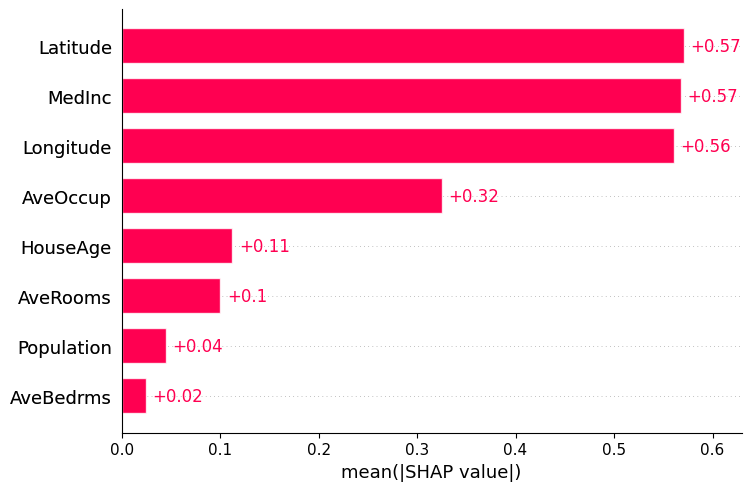

In [13]:
shap.plots.bar(shap_values[0:19])

Another well-knon example is the *bee swarm* plot, which depicts essentially the same information but at a more granular level.

### Beeswarm plot
The plot gives an overview of which features are most important for a model by plotting the SHAP values of every feature for every sample. The plot sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a low value for the feature MedInc (median income in block group) lowers the predicted home price. Specifically, a low feature value is associated with negative SHAP values. On the other hand, high values for this features go hand in hand with high SHAP values. Clear patterns like this may be taken as evidence for a monotonic relationship between MedInc and model forecast. Importantly, this does NOT imply that the true relationship is also monotonic (we only explain our model and this model might be wrong). Likewise, make sure to not confuse monotonic with linear. 

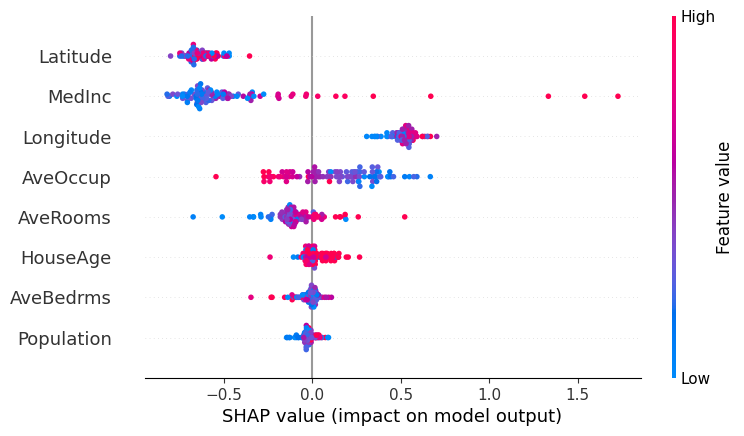

In [16]:
shap.plots.beeswarm(shap_values[0:99])

We end the demo at this point. There are yet more plots to discover but you got an overall idea of the library, and how we can easily create different types of plots using inbuilt functions. Have a look at the [GitHub repo](https://github.com/shap/shap/tree/master) for more demos. 
Given that the plots, and the whole concept of SHAP, are nontrivial, the most important thing is to familiarize yourself with those plots and learn to interpret them. To that end, we map out a programming task for you in the next part.

## Programming Task
To get used to the SHAP library, you can work on the following exercise. We provide a snipped of Python code to load a different data set, namely a credit scoring data set, and train an ML model to predict the probability of credit applicants defaulting on a loan. Note that this involves classification. Above, we predicted house prices using regression. A price is a number and so we employed a regression model to predict continuous outcomes. Repayment of default (i.e., failure to pay back a credit) are discrete outcomes and we need a classification model to predict these outcomes. 

As you will see, switching from regression to classification do not changes things fundamentally; neither in the actual model training nor when explaining a model using SHAP. However, depending on your coding skills, reproducing the previous analysis might prove a little challenging. Have fun ;)

In [17]:
# Load the data for this demo notebook directly from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv'

print('Fetching data...')
df = pd.read_csv(data_url, index_col='index')

# Perform a minimal bit of preprocessing
df['DEROGzero'] = df['DEROGzero'].astype('int64')

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']].values
X_var_labels = df.columns[1:df.shape[1]]

# Partition data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

# Make yourself familiar with these vectors
print('Shape of the data ', y_train.shape, X_train.shape, y_test.shape, X_test.shape)

Fetching data...
Shape of the data  (4172, 1) (4172, 18) (1788, 1) (1788, 18)


### The HMEQ data set
Our data set, called the  "Home Equity" or, in brief, HMEQ data set, is provided by www.creditriskanalytics.net. It comprises  information about a set of borrowers, which are categorized along demographic variables and variables concerning their business relationship with the lender. A binary target variable called 'BAD' is  provided and indicates whether a borrower has repaid her/his debt. You can think of the data as a standard use case of binary classification.

You can obtain the data, together with other interesting finance data sets, directly from www.creditriskanalytics.net. The website also provides a brief description of the data set. Specifically, the data set consists of 5,960 observations and 13 features including the target variable. The variables are defined as follows:

- BAD: the target variable, 1=default; 0=non-default 
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

As you can see, the features aim at describing the financial situation of a borrower. Make sure you understand what type of information they provide and what this information might reveal about the risk of defaulting.  

### Train a classification model
Now that the data is available, your task is to train an ML model on the data to predict the target variable. To ensure compatibility with SHAP, I suggest you use XGB or a tree-based sklearn classifier like Random Forest or GBM. You could also use other algorithms but note that the call `shap.Explainer(model)` will check the type of algorithm. The fast TreeSHAP approximation cannot be used with all learning algorithms so in the interest of speed, you should stick to XGB, GBM or Random Forest.

In [4]:
# Put your code to train the ML model here


After training, you should predict the test data and, for fun, assess your model. One intuitive way to do so involves creating a confusion matrix. We provide the code below. To run this code, make sure you create a variable `yhat`, to store the test set predictions.

Classification accuracy:  0.8853467561521253


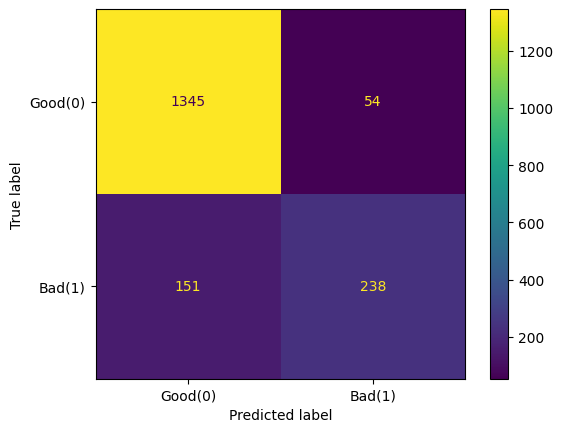

In [4]:
# Compute a performance indicator over the test set predictions.
from sklearn.metrics import ConfusionMatrixDisplay

# Make sure to have test set predictions available in a variable yhat

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=yhat, labels=[0, 1], display_labels=['Good(0)', 'Bad(1)']);

## XAI
From here on, you need no more guidance. Go through the above examples for the California Housing data sets and produce similar insights (i.e., plots) for your credit risk model.